In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import regularizers

In [91]:
train_data_path = './google_stock/Google_Stock_Price_train.csv'
test_data_path = './google_stock/Google_Stock_Price_test.csv'

In [92]:
df_train = pd.read_csv(train_data_path)
print(df_train.head())
print("*"*20)
df_test = pd.read_csv(test_data_path)
df_test.head()

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
********************


,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [93]:
print(f"Shape: \n{df_train.shape}")
print(f"Null Values: \n{df_train.isnull().values.sum()}")
print(f"Duplicated_values:\n {df_train.duplicated(subset=['Date']).value_counts()}")
print("*"*20)
print(f"Shape: \n{df_test.shape}")
print(f"Null Values: \n{df_test.isnull().values.sum()}")
print(f"Duplicated_values:\n{df_test.duplicated(subset=['Date']).value_counts()}")

Shape: 
(1258, 6)
Null Values: 
0
Duplicated_values:
 False    1258
Name: count, dtype: int64
********************
Shape: 
(20, 6)
Null Values: 
0
Duplicated_values:
False    20
Name: count, dtype: int64


In [94]:
df_train.info()
print("*"*20)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [95]:
def convert_to_float(series):
    try:
        float(series)
        return True
    except:
        return False

In [96]:
invalid_rows_close = df_train[~df_train['Close'].apply(convert_to_float)]
print(invalid_rows_close)

           Date    Open    High     Low     Close      Volume
451  10/18/2013  486.47  505.83  485.18  1,008.64  23,219,400
452  10/21/2013  503.84  507.60  497.91  1,000.55   7,283,700
453  10/22/2013  500.62  504.61  496.04  1,004.24   4,433,700
454  10/23/2013  498.63  515.44  498.45  1,028.59   5,346,300
455  10/24/2013  514.01  518.34  510.49  1,022.74   4,199,700
..          ...     ...     ...     ...       ...         ...
555   3/20/2014  597.73  602.55  595.45  1,193.88   3,381,900
556   3/21/2014  600.90  602.56  589.02  1,179.80   6,441,000
557   3/24/2014  589.88  590.24  570.84  1,154.76   6,096,800
558   3/25/2014  580.82  582.74  571.36  1,155.55   4,838,400
559   3/26/2014  578.84  583.60  563.64  1,128.87   5,179,200

[109 rows x 6 columns]


In [97]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(",", ""), errors='coerce')
df_train['Volume'] = pd.to_numeric(df_train['Volume'].str.replace(",", ""), errors='coerce')

In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [99]:
df_test['Volume'] = pd.to_numeric(df_test['Volume'].str.replace(",", ""), errors='coerce')


In [100]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ KB
None


In [12]:
import plotly.graph_objects as go

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df_train['Date'],
                                     open=df_train['Open'],
                                     high=df_train['High'],
                                     low=df_train['Low'],
                                     close=df_train['Close'])])

# Set the figure size using layout
fig.update_layout(
    width=1000,  # Width in pixels
    height=500, # Height in pixels
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price'
)

# Show the figure
fig.show()


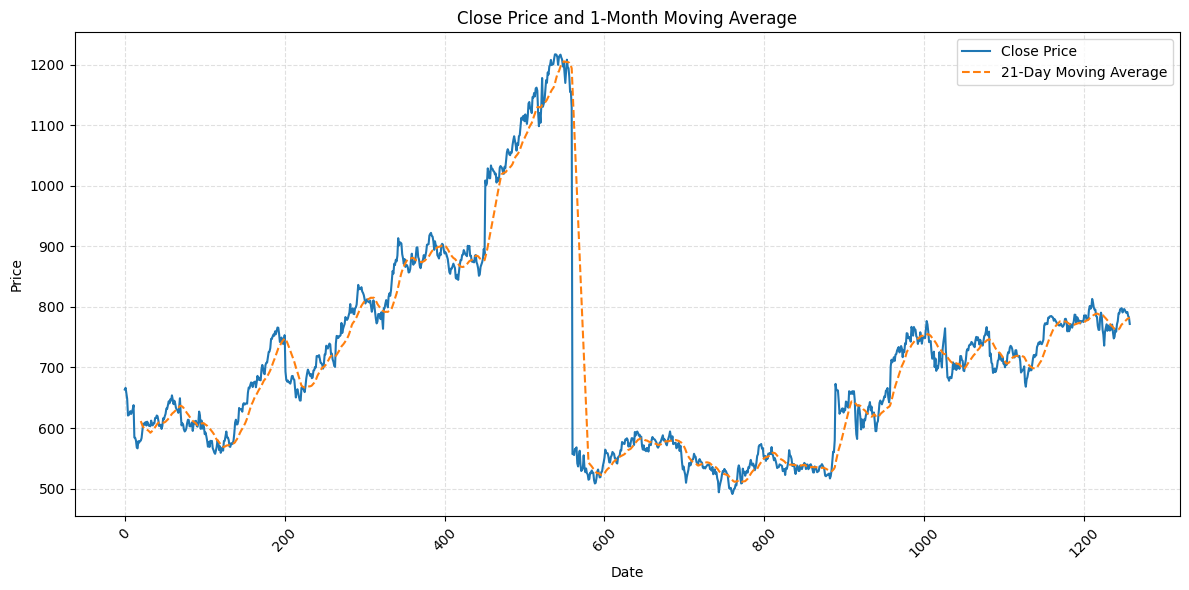

In [13]:
# Calculate the 1-month (21-day) moving average
df_train['21-Day MA'] = df_train['Close'].rolling(window=21).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_train['Close'], label='Close Price')
plt.plot(df_train['21-Day MA'], label='21-Day Moving Average', linestyle='--')

# Customize grid lines
plt.grid(True, linestyle='--', color='lightgray', alpha=0.7)

plt.title('Close Price and 1-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [14]:
df_train.set_index(['Date'], inplace=True)

In [15]:
df_train.head()

,Open,High,Low,Close,Volume,21-Day MA
Date,,,,,,
1/3/2012,325.25,332.83,324.97,663.59,7380500,NaN
1/4/2012,331.27,333.87,329.08,666.45,5749400,NaN
1/5/2012,329.83,330.75,326.89,657.21,6590300,NaN
1/6/2012,328.34,328.77,323.68,648.24,5405900,NaN
1/9/2012,322.04,322.29,309.46,620.76,11688800,NaN


In [16]:
df_train.drop(columns=['21-Day MA'], inplace= True)

In [17]:
returns = df_train['Close'].pct_change()
returns.index = pd.to_datetime(returns.index)


## Univarient Forecasting (RNN)

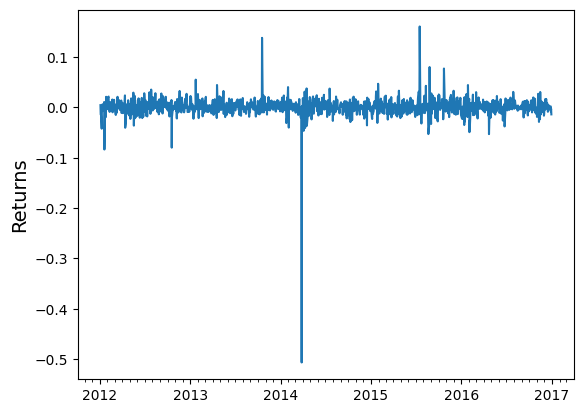

In [18]:
# Create locators for ticks on the time axis
years = mdates.YearLocator()
month = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

ax1 = plt.gca()
ax1.plot(returns.index, returns.values)

ax1.set_ylabel('Returns', fontsize=14)

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())


<Axes: >

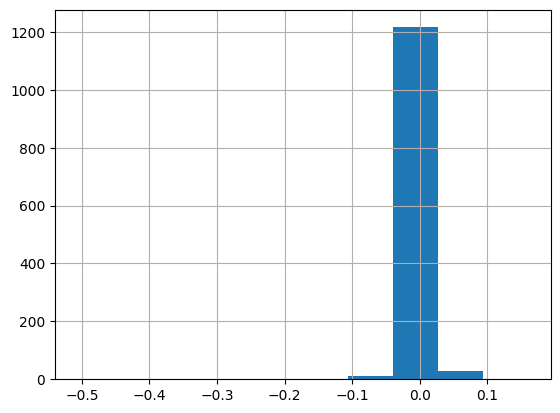

In [19]:
returns.hist()

In [20]:
univarient = returns.values[1:].reshape(-1,1)
print(len(univarient))
scale = MinMaxScaler()
univarient = scale.fit_transform(univarient)
univarient



1257


array([[0.76585609],
       [0.73861516],
       [0.73893877],
       ...,
       [0.74708789],
       [0.75508123],
       [0.73839113]])

In [21]:
univarient.shape

(1257, 1)

In [22]:
samples = 10
steps = 1
X = []
y = []
for i in range(univarient.shape[0] -samples):
    X.append(univarient[i:i+samples])
    y.append(univarient[i+samples][0])

print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(y[0:1]),': ', y[0:1])

Training Data: Length is  10 :  [array([[0.76585609],
       [0.73861516],
       [0.73893877],
       [0.6958568 ],
       [0.76101391],
       [0.76619787],
       [0.76820805],
       [0.74832034],
       [0.76800533],
       [0.76972555]])]
Testing Data: Length is  1 :  [0.7751641565483469]


In [23]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
y = np.array(y)
print('Dimensions of X', X.shape, 'Dimensions of y', y.shape)

Train = round(0.9 * X.shape[0])
print('Threshold is', Train)


Dimensions of X (1247, 10, 1) Dimensions of y (1247,)
Threshold is 1122


When working with sequence data (such as time series or recurrent neural network inputs), the shape (samples, time steps, features) is commonly used:

Samples: How many sequences or samples you have (1247 in your case).
Time Steps: The length of each sequence (10 in your case).
Features: The number of different features at each time step (1 in your case).

In [24]:
# Initialize the Sequential model
model = keras.Sequential()

# Add an Input layer specifying the shape of the input data
model.add(keras.layers.Input(shape=(X.shape[1], X.shape[2])))

# Add a SimpleRNN layer with 50 units
model.add(keras.layers.SimpleRNN(50, 
                                 activation='tanh', 
                                 use_bias=True,
                                 recurrent_dropout=0.4,
                                 kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer to prevent overfitting
model.add(keras.layers.Dropout(rate=0.4))

# Add a Dense layer with 1 unit for regression output
model.add(keras.layers.Dense(1))

# Compile the model using Mean Squared Error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print out the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,   # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True  # Restore the best weights when stopping
)

# Fitting the data
history = model.fit(X[:Train],
                    y[:Train],
                    shuffle = False, # Since this is time series data
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.8499 - val_loss: 0.0825
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4068 - val_loss: 0.0664
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3264 - val_loss: 0.0669
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2769 - val_loss: 0.0458
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2489 - val_loss: 0.0392
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2032 - val_loss: 0.0503
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1772 - val_loss: 0.0285
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1721 - val_loss: 0.0319
Epoch 9/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1238 - val_loss: 0.0259
Epoch 10/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1228 - val_loss: 0.0300
Epoch 11/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0971 - val_loss: 0.0261
Epoch 12/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1030 - val_

In [26]:
def test_data_accuracy(df_test):
    # df_test = df_test.reset_index( drop=True, inplace=True)
    df_test['Date'] = pd.to_datetime(df_test['Date'])
    df_test.set_index(['Date'], inplace=True)
    test_returns = df_test['Close'].pct_change()
    test_val = test_returns[1:].values.reshape(-1,1)
    mm= MinMaxScaler()
    test_val = mm.fit_transform(test_val)

    samples = 10
    steps = 1
    X_test = []
    y_test = []
    for i in range(test_val.shape[0] -samples):
        X_test.append(test_val[i:i+samples])
        y_test.append(test_val[i+samples][0])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    predictions = model.predict(X_test)
    print(f"Model loas is {model.evaluate(X_test, y_test)}")
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

    

In [27]:

test_data_accuracy(df_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0995
Model loas is 0.0995359793305397
Mean Squared Error: 0.07969941454180146


## Multivarient forcasting

In [104]:
df_train_1 = df_train.copy()
df_train_1 = df_train_1.iloc[: , 1:]

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800


In [107]:
scaler = MinMaxScaler()
for column in df_train_1.columns:
    df_train_1[column] = scaler.fit_transform(df_train_1[[column]])
df_train_1.head()


,Open,High,Low,Close,Volume
0,0.085814,0.096401,0.090449,0.237573,0.295258
1,0.097012,0.098344,0.098235,0.241514,0.229936
2,0.094334,0.092517,0.094086,0.228781,0.263612
3,0.091562,0.088819,0.088006,0.216419,0.216179
4,0.079842,0.076718,0.061070,0.178548,0.467797


In [108]:
df_train_1.shape

(1258, 5)

In [110]:
samples = 10
step = 1
X = []
Y = []
for i in range(df_train_1.shape[0]-samples):
    X.append(df_train_1.iloc[i:i+samples, 0:].values)
    Y.append(df_train_1.iloc[i+samples, 3])

print(f"The length of X is {len(X)}\n {X[0]}")
print(f"The length of Y is {len(Y)}\n {Y[0]}")

The length of X is 1248
 [[0.08581368 0.09640129 0.09044931 0.23757287 0.29525831]
 [0.09701243 0.09834351 0.09823458 0.24151427 0.22993592]
 [0.09433366 0.09251685 0.09408623 0.22878051 0.26361233]
 [0.09156187 0.08881917 0.08800576 0.21641884 0.21617942]
 [0.07984225 0.07671765 0.06106986 0.1785483  0.46779736]
 [0.0643277  0.06444805 0.05697833 0.17947163 0.35306768]
 [0.0585423  0.06033951 0.06095621 0.18335791 0.19262715]
 [0.06568569 0.063589   0.06603273 0.18841558 0.15044053]
 [0.06109085 0.05806114 0.06089938 0.18202114 0.18517821]
 [0.06639259 0.06274861 0.0652561  0.18695478 0.15317982]]
The length of Y is 1248
 0.19290823146782787


In [111]:
X = np.array(X)
print(X.shape)
Y = np.array(Y)
print(Y.shape)


(1248, 10, 5)
(1248,)


In [113]:
Y = Y.reshape(-1,1)
print(Y.shape)

(1248, 1)


In [140]:
# Let's build the RNN
model1 = keras.Sequential()

# Add an Input layer specifying the shape of the input data
model1.add(keras.layers.Input(shape=(X.shape[1], X.shape[2])))

# Add a RNN layer with 40 internal units.
model1.add(keras.layers.SimpleRNN(32,
                           activation = 'tanh',
                           use_bias=True,
                           recurrent_dropout = 0.2))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model1.add(keras.layers.Dropout(rate=0.3))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model1.add(keras.layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model1.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Fitting the data
history = model1.fit(X,
                    Y,
                    shuffle = False, # Since this is time series data
                    epochs=20,
                    batch_size=32,
                    verbose=1) # Verbose outputs data

Epoch 1/20


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3699
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2095
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1087
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0431
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 16/20
39/39 ━━━━━━━━━━━━

In [142]:
def test_data_accuracy(df_test):
    df_test1 = df_test.iloc[: , 1:]
    mm= MinMaxScaler()
    for column in df_train_1.columns:
        df_test1[column] = mm.fit_transform(df_test1[[column]])
    samples = 10
    X_test = []
    y_test = []
    for i in range(df_test1.shape[0] -samples):
        X_test.append(df_test1.iloc[i:i+samples, 0:].values)
        y_test.append(df_test1.iloc[i+samples, 3])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    predictions = model1.predict(X_test)
    print(f"Model loss is {model1.evaluate(X_test, y_test)}")
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

In [143]:
test_data_accuracy(df_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0397
Model loss is 0.03972412273287773
Mean Squared Error: 0.03972411967504335
